Perform MNIST classification using Neural Netwroks and Convolutional Neural Networks.

1) Use 10 iterations for training


2) Show the training loss for both networks on the same plot


3) Compare the test loss and accuracy.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models,transforms
from torchvision.utils import make_grid
from torchvision.datasets import MNIST
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
from torch.utils.data import DataLoader
import torchmetrics as tm

In [ ]:
# MNIST
def mnist(batch_sz, valid_size=0.2, shuffle=True, random_seed=2000):
    num_classes = 10
    transform_train = transforms.Compose([
                        transforms.RandomCrop(28, padding=4),
                        transforms.ToTensor(),
                    ])
    
    
    transform_test = transforms.Compose([
                        transforms.ToTensor(),
                    ])
    

    # Training dataset
    train_data = MNIST(root='./datasets', train=True, download=True, transform=transform_train)
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    if shuffle == True:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_sz ,pin_memory=True)

    # Test dataset
    test_data = MNIST(root='./datasets', train=False, download=True, transform=transform_test)
    test_loader = torch.utils.data.DataLoader(test_data,
                                              batch_size=batch_sz, shuffle=False, pin_memory=True)

    return train_loader, test_loader



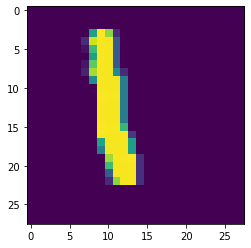

In [ ]:
batch_sz=64 # this is batch size i.e. the number of rows in a batch of data

train_loader, test_loader=mnist(batch_sz) 

tl = iter(train_loader)
batch = next(tl)


plt.imshow(batch[0][6,:,:,:].squeeze())

In [ ]:
# Define the classes for the classic Neural Network and the Convolutional Neural Network


class NN(nn.Module):
    def __init__(self, input_size=784, output_classes=10) -> None:
        super(NN, self).__init__()
        self._layer_in = nn.Linear(input_size, 1024)
        self._layer_h = nn.Linear(1024,512)
        self._layer_out = nn.Linear(512, output_classes)

    def forward(self, x):
        x = torch.relu(self._layer_in(x))
        x = torch.relu(self._layer_h(x))
        x = self._layer_out(x)

        return x


        

class NNet(nn.Module):
    def __init__(self, input_size=784, output_size=10, no_hidden_layers=5,hidden_layer_size=1024) -> None:
        super(NNet,self).__init__()
        self.deep_nn = nn.Sequential()
        
        for i in range(no_hidden_layers):
            self.deep_nn.add_module(f'ff{i}', nn.Linear(input_size,hidden_layer_size))
            self.deep_nn.add_module(f'activation{i}',nn.ReLU())
            input_size = hidden_layer_size

        self.deep_nn.add_module(f'classifier',nn.Linear(hidden_layer_size,output_size))

    def forward(self, x):
        tensor = self.deep_nn(x)
        return tensor


# CNN

class CNN(nn.Module):
    def __init__(self, in_channels=1,num_classes=10) -> None:
        super(CNN,self).__init__() # In the other tutorial he is using CNN and self within the super(CNN, self) brakets

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3,3),stride=(1,1),padding=(1,1))  #  3 -1 /2 ; 3 being the filter_size, with padding the image size stays the same
        self.maxpool = nn.MaxPool2d(kernel_size= (2,2), stride= (2,2))
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3,3),stride=(1,1),padding=(1,1))
        self._in = nn.Linear(16*7*7, 128)
        # self.h1 = nn.Linear(1024,1024) # remove and adjust dims to recover AC2
        # self.h2 = nn.Linear(1024,128)
        self.lin_out = nn.Linear(128,num_classes) # change 128 to 16*7*7 for AC1


    # Forward Pass
    
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.maxpool(x)
        x = torch.relu(self.conv2(x))
        x = self.maxpool(x)

        # Linear Model
        x = x.reshape(x.shape[0], -1)
        x = torch.relu(self._in(x))
        # x = torch.relu(self.h1(x))
        # x = torch.relu(self.h2(x))
        x = self.lin_out(x)
            
        return x





In [ ]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

print(device)

cpu


In [ ]:
# Model 1 Dim Testing
model_1 = NNet().to(device=device)
x = torch.randn(64,784)
print(model_1(x).shape)

# Model 2 Dim Testing

model_2 = CNN().to(device=device)
x = torch.randn(64,1,28,28)
print(model_2(x).shape)

torch.Size([64, 10])
torch.Size([64, 10])


In [ ]:
# Hyperparameter: 

inputs = 784
mm = 0
batch_sz=64
epoch_no = 3
mini_batches = [64]
learning_rates = [0.1,0.01,0.001,0.0001]
learning_rates = learning_rates[::-1]

In [ ]:
# Data Option 1:

def unbiased_data(batch_sz):
    train_dataset = MNIST(root="dataset/", train=True, transform=transforms.ToTensor(), download=True)
    test_dataset = MNIST(root="dataset/", train=False, transform=transforms.ToTensor(), download=True)
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_sz, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_sz, shuffle=True)

    return train_loader, test_loader


In [ ]:
# Data Option 2:
# MNIST
def mnist(batch_sz, valid_size=0.2, shuffle=True, random_seed=2000):
    num_classes = 10
    transform_train = transforms.Compose([
                        transforms.RandomCrop(28, padding=4),
                        transforms.ToTensor(),
                    ])
    
    
    transform_test = transforms.Compose([
                        transforms.ToTensor(),
                    ])
    

    # Training dataset
    train_data = MNIST(root='./datasets', train=True, download=True, transform=transform_train)
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    if shuffle == True:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_sz ,pin_memory=True)

    # Test dataset
    test_data = MNIST(root='./datasets', train=False, download=True, transform=transform_test)
    test_loader = torch.utils.data.DataLoader(test_data,
                                              batch_size=batch_sz, shuffle=False, pin_memory=True)

    return train_loader, test_loader

In [ ]:
# Training and Testing
def var_training(data_bias=True,model=CNN(),type_CNN = True):
    for mini_batch in mini_batches:
        for learning_rate in learning_rates:
            model_2 = model.to(device=device)
        
            # write to tensorboard
            step = 0

            if data_bias == True and type_CNN == True:
                writer = SummaryWriter(f'runs/MNIST/CNN_rand_bs={mini_batch}_lr={learning_rate}')
            elif data_bias == False and type_CNN == True:
                writer = SummaryWriter(f'runs/MNIST/CNN_bias_bs={mini_batch}_lr={learning_rate}')
            elif data_bias == True and type_CNN == False:
                writer = SummaryWriter(f'runs/MNIST/NN_wS_rand_bs={mini_batch}_lr={learning_rate}')
            else:
                writer = SummaryWriter(f'runs/MNIST/NN_wS_bias_bs={mini_batch}_lr={learning_rate}')


            # Loss and optimizer
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.SGD(model_2.parameters(), lr=learning_rate, momentum= mm)
            scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer,gamma=0.9,verbose=False)

            # generate new data

            if data_bias == True:
                train_loader, test_loader=mnist(mini_batch)

            else:
                train_loader, test_loader=unbiased_data(mini_batch)
            
            for epoch in range(epoch_no):
                train_loss = 0
                for batch_idx, (data, targets) in enumerate(train_loader):
                    data = data.to(device=device)
                    targets = targets.to(device=device)

                    if type_CNN == False:
                        data = data.reshape(data.shape[0], -1)
                    else:
                        pass

                    # forwards
                    logits = model_2(data)
                    loss = criterion(logits, targets)
                    train_loss += loss.item()


                    # backward 
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    # scheduler.step()

                    # Running Accuracy
                    _, predictions = logits.max(1)
                    num_corr = (predictions == targets).sum()
                    running_acc = float(num_corr)/float(data.shape[0])
                    
                    writer.add_scalar("Training Loss", loss, global_step = step) 
                    writer.add_scalar("Training Accuracy", running_acc, global_step=step)
                    step += 1  

                scheduler.step()

            acc_l = []

            accuracy = tm.Accuracy()

            with torch.no_grad():
                step_2 = 0
                for batch_idx, (data, targets) in enumerate(test_loader):
                    data = data.to(device=device)
                    targets = targets.to(device=device)

                    if type_CNN == False:
                        data = data.reshape(data.shape[0], -1)
                    else:
                        pass

                    logits = model_2(data)
                    t_loss = criterion(logits, targets)
                    train_loss += loss.item()

                    yhat = torch.argmax(logits, axis =1)

                    acc = accuracy(yhat.to("cpu"),targets.to("cpu"))

                    acc_l.append(acc)

                    writer.add_scalar("Testing Loss", t_loss, global_step = step_2) 
                    writer.add_scalar("Testing Accuracy", acc, global_step=step_2)
                    step_2 += 1

            print(f'the accuracy on the test set for the batch size: {mini_batch} and learning rate: {learning_rate} is {np.mean(acc_l):.2f}')




In [ ]:
var_training(data_bias=True,model=CNN(),type_CNN=True)

the accuracy on the test set for the batch size: 64 and learning rate: 0.0001 is 0.11
the accuracy on the test set for the batch size: 64 and learning rate: 0.001 is 0.13
the accuracy on the test set for the batch size: 64 and learning rate: 0.01 is 0.87
the accuracy on the test set for the batch size: 64 and learning rate: 0.1 is 0.97


In [ ]:
var_training(data_bias=True,model=NN(),type_CNN=False)

Adjusting learning rate of group 0 to 1.0000e-04.
Adjusting learning rate of group 0 to 9.0000e-05.
Adjusting learning rate of group 0 to 8.1000e-05.
Adjusting learning rate of group 0 to 7.2900e-05.
the accuracy on the test set for the batch size: 64 and learning rate: 0.0001 is 0.10
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 9.0000e-04.
Adjusting learning rate of group 0 to 8.1000e-04.
Adjusting learning rate of group 0 to 7.2900e-04.
the accuracy on the test set for the batch size: 64 and learning rate: 0.001 is 0.20
Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 9.0000e-03.
Adjusting learning rate of group 0 to 8.1000e-03.
Adjusting learning rate of group 0 to 7.2900e-03.
the accuracy on the test set for the batch size: 64 and learning rate: 0.01 is 0.74
Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 9.0000e-02.
Adjusting learning rate of group 0 to 8.1000e

# Results

### Training Loss and Training Accuracy

Both models performed well on the training set. Especially with a learning rate of 0.1 both models achieved accuracies around 95% (CNN 97%, NN 95%). With lower learing rates the CNN generally outperformed the NN.

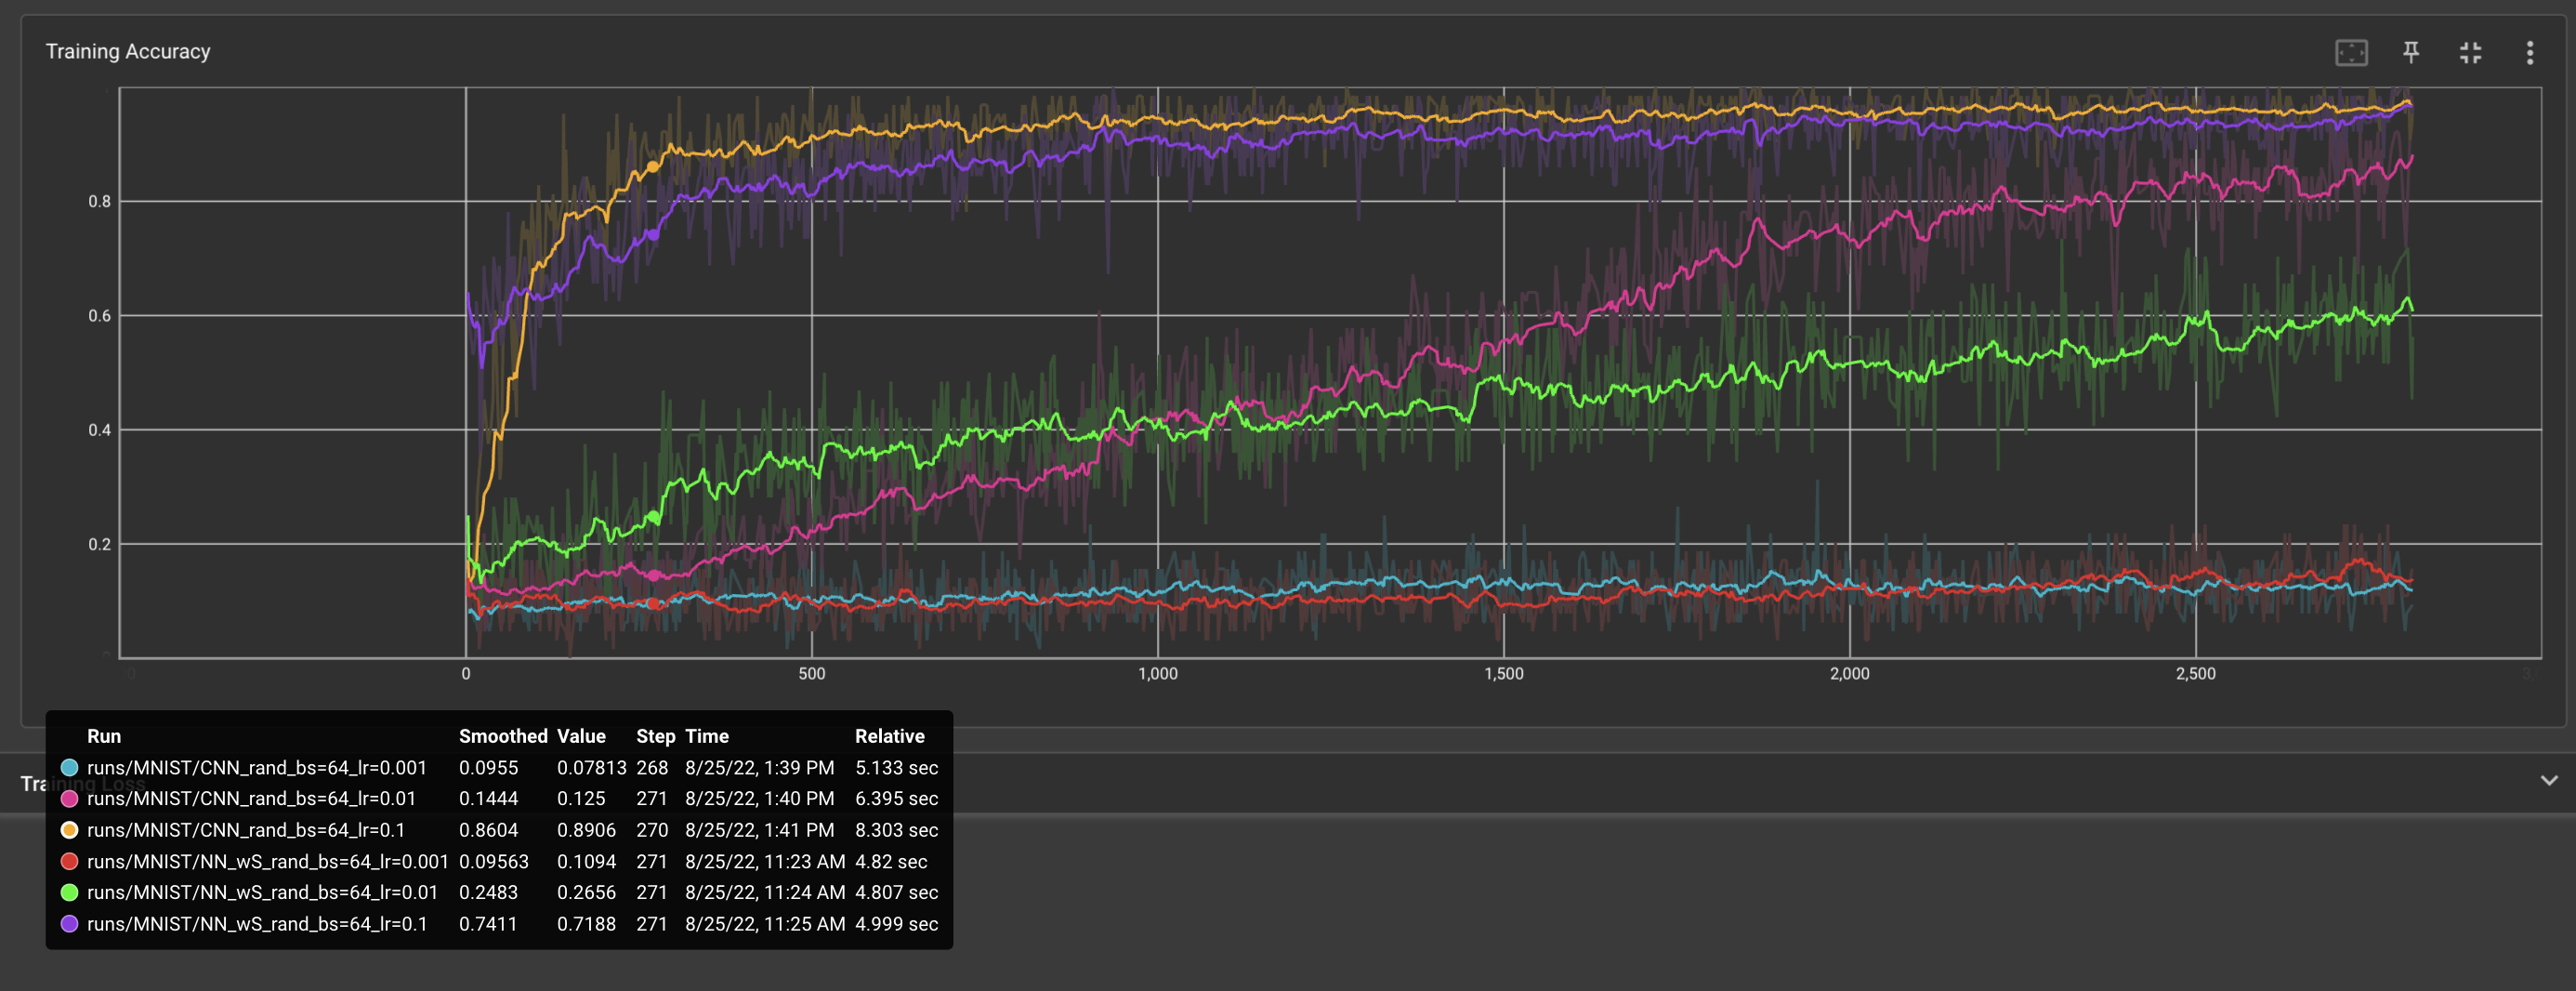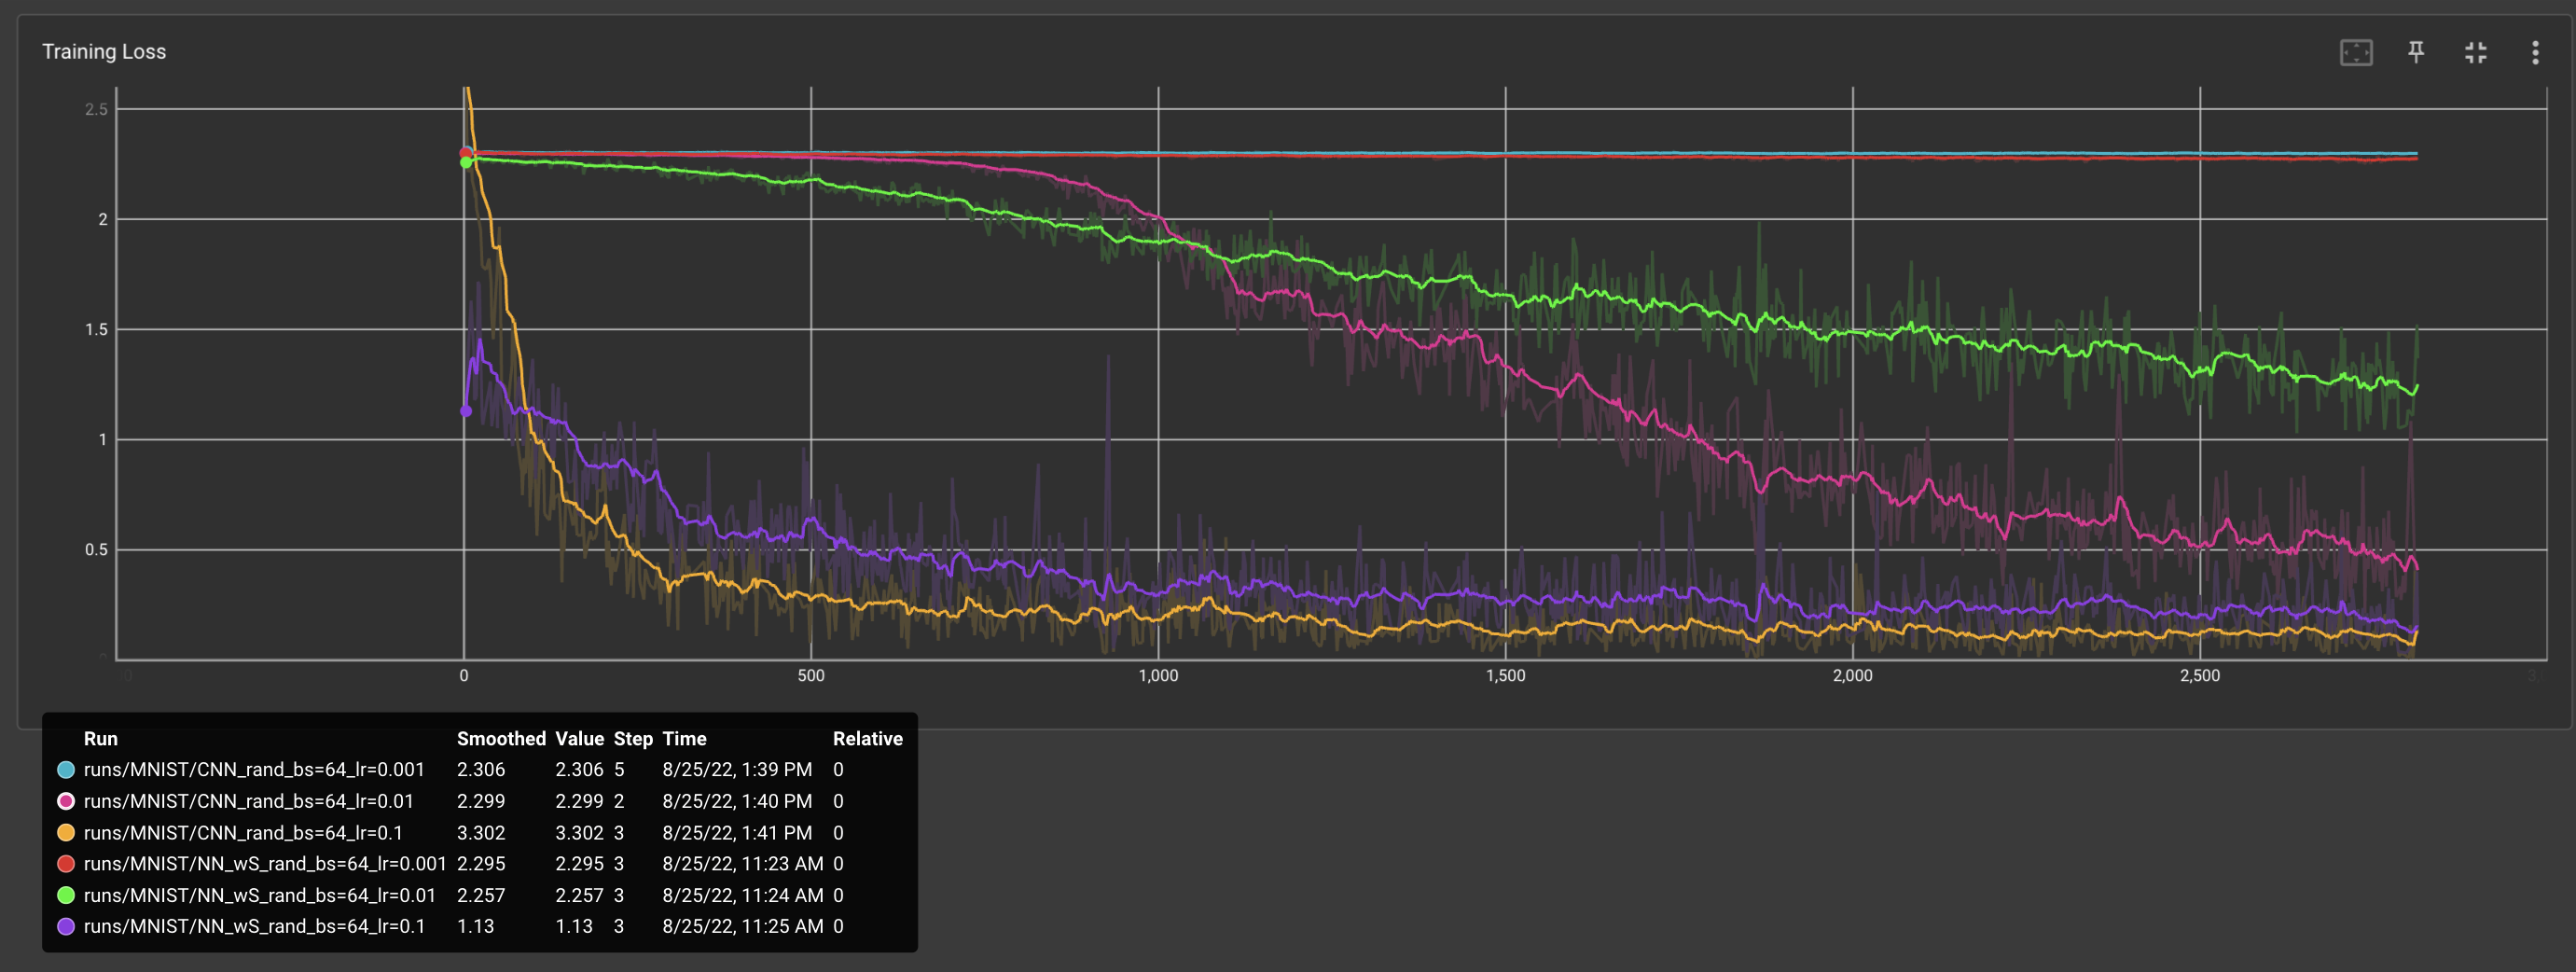

### Training Loss and Training Accuracy 

In testing the CNN generally outperformed the NN with a small margin for higher learning rates. Lower learing rates gave marginal advantages to the NN.

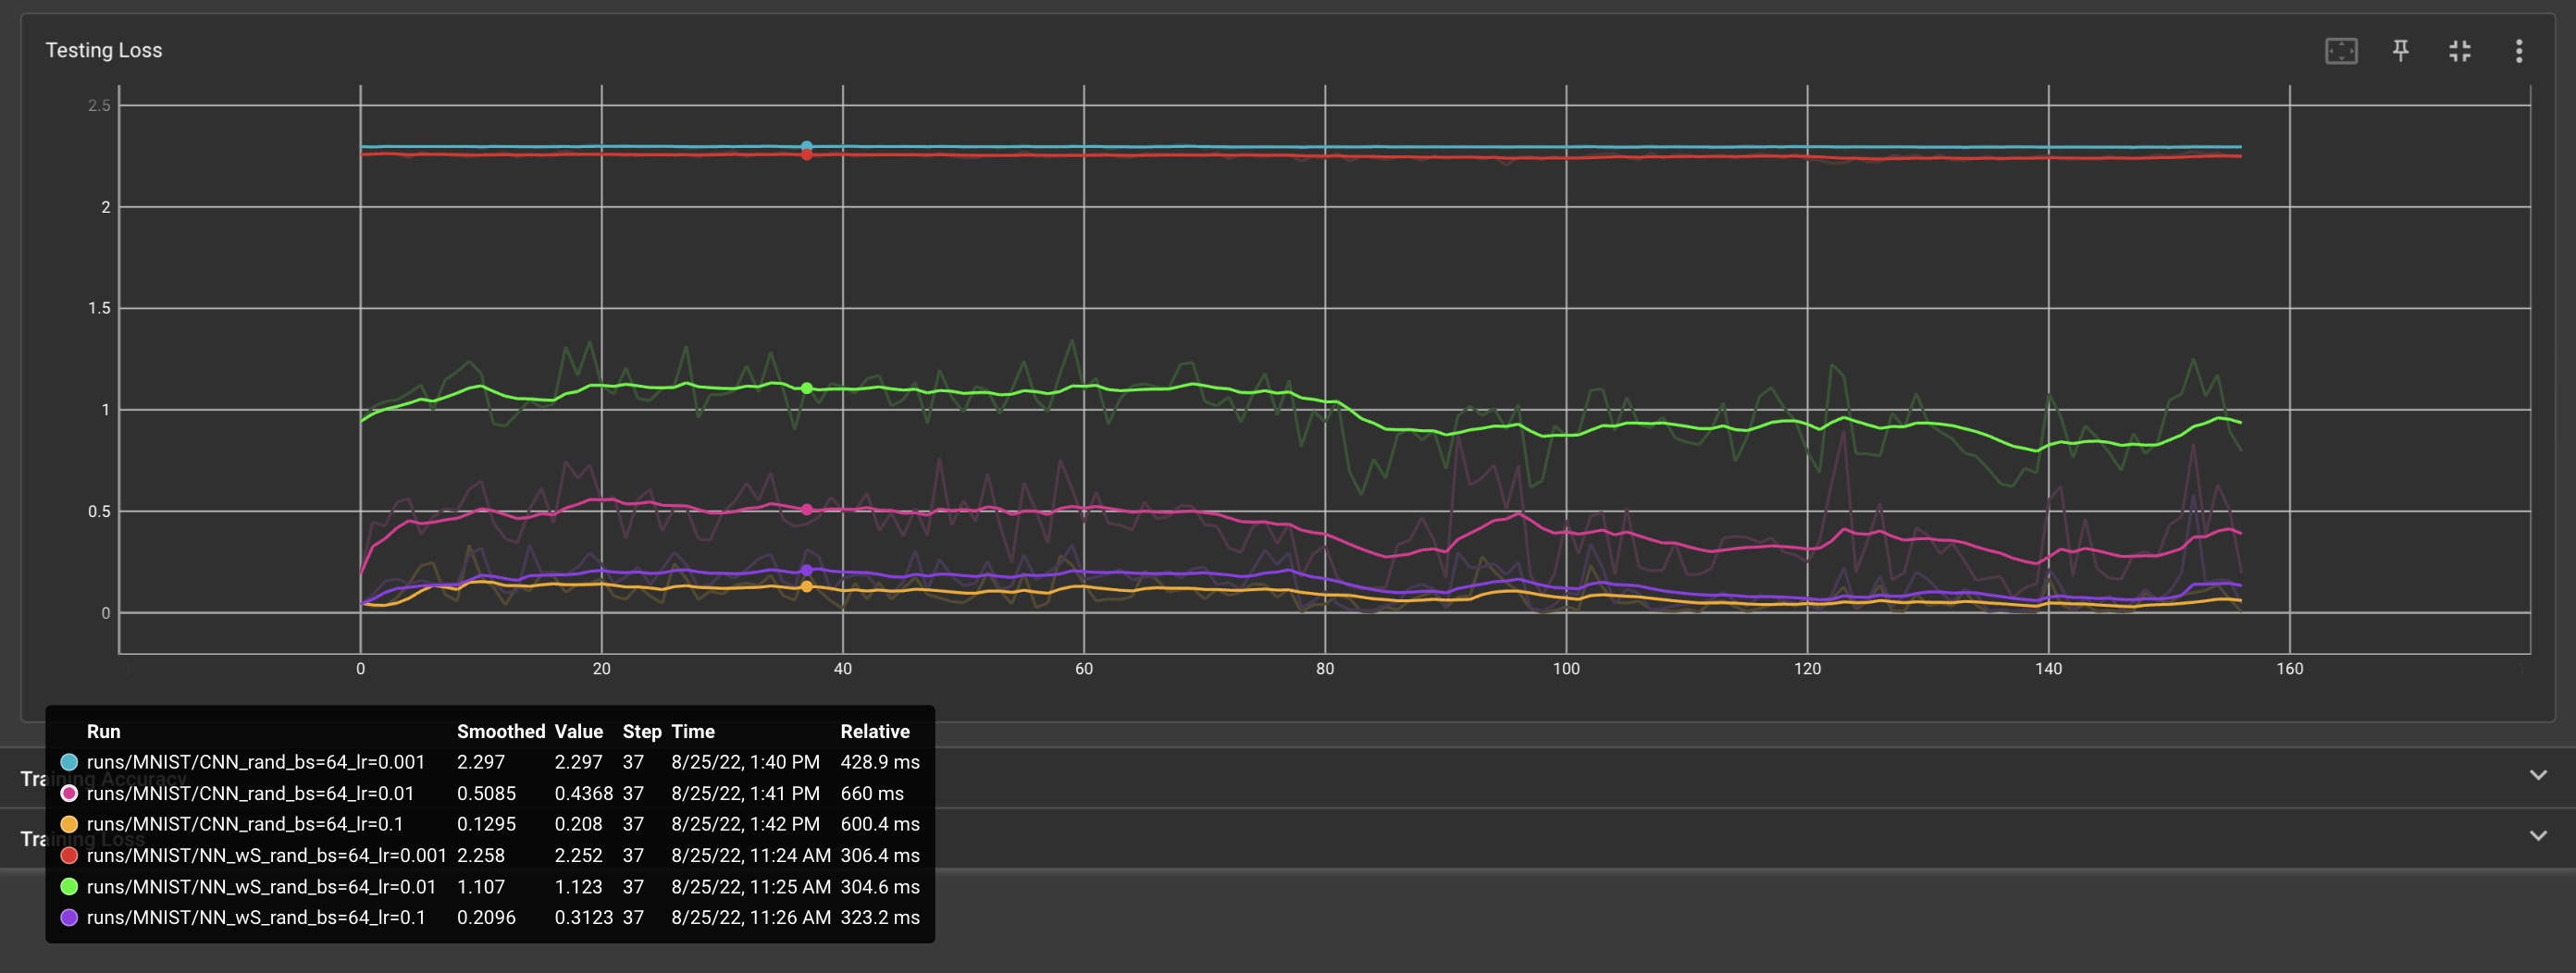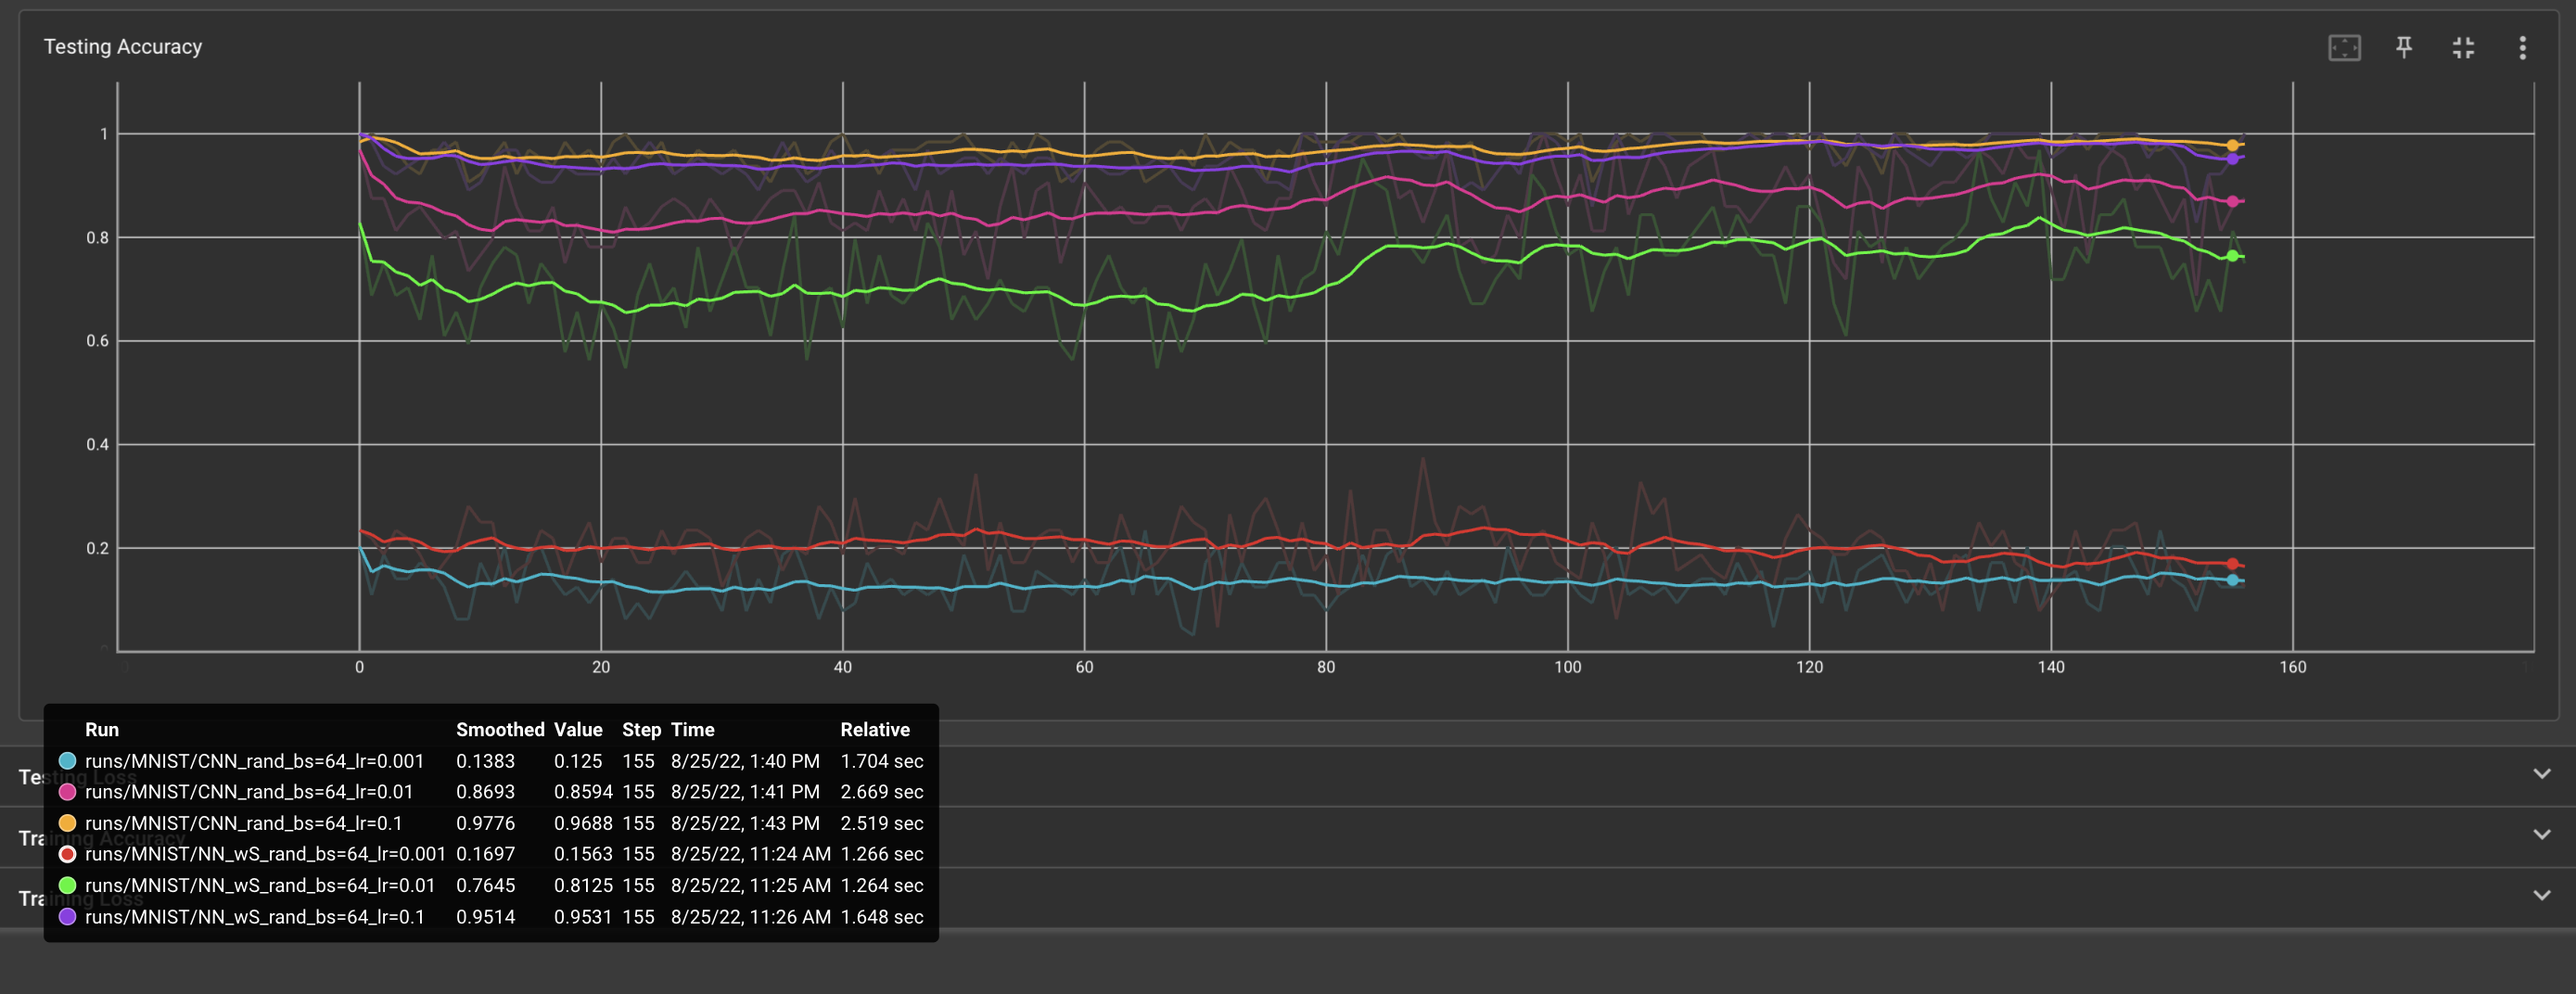